<a href="https://colab.research.google.com/github/ziatdinovmax/Notebooks-for-papers/blob/master/BEPS_Im2Spec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This notebook may be outdated. The up-to-date code and examples for im2spec and spec2im modelling are available at https://github.com/ziatdinovmax/im2spec**

# Interactive notebook for paper "Decoding the relationship between domain structure and functionality in ferroelectrics via hidden latent variables"

Sergei V. Kalinin, Rama K. Vasudevan, and Maxim Ziatdinov

The Center for Nanophase Materials Sciences, Oak Ridge National Laboratory, Oak Ridge, TN 37831

Installations:

In [ ]:
!pip install -q pycroscopy gpim 2> /dev/null

     |████████████████████████████████| 348kB 3.3MB/s 
     |████████████████████████████████| 788kB 45.7MB/s 
     |████████████████████████████████| 61kB 7.3MB/s 
     |████████████████████████████████| 153kB 41.8MB/s 
     |████████████████████████████████| 245kB 46.6MB/s 
     |████████████████████████████████| 522kB 50.7MB/s 
     |████████████████████████████████| 358kB 43.2MB/s 
     |████████████████████████████████| 481kB 48.3MB/s 


Import packages:

In [ ]:
import os
from typing import List, Tuple

import h5py
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import decomposition
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split

import pyUSID as usid

# Read/inspect dataset

Download data

In [ ]:
!gdown https://drive.google.com/uc?id=1_KEQw2xuxPGexnwNaIOgbvCCDnk9ui12

Downloading...
From: https://drive.google.com/uc?id=1_KEQw2xuxPGexnwNaIOgbvCCDnk9ui12
To: /content/pto_50x50_2ndarea_0002.h5
289MB [00:02, 106MB/s] 


Load data into the notebook and view its structure:

In [ ]:
h5_f = h5py.File(r'pto_50x50_2ndarea_0002.h5', 'r+')
usid.hdf_utils.print_tree(h5_f)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Bin_Wfm_Type
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Raw_Data-SHO_Fit_000
      --------------------
      ├ Fit
      ├ Guess
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
    ├ Spatially_Averaged_Plot_Group_000
      ---------------------------------
      ├ Bin_Frequencies
      ├ Mean_Spectrogram
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ UDVS
    ├ UDVS_Indices


Read measurements:

In [ ]:
sho_mat = h5_f['Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Fit']
spec_val = h5_f['Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Spectroscopic_Values']
pos_inds = h5_f['Measurement_000/Channel_000/Position_Indices']
pos_dim_sizes = [np.max(pos_inds[:,0])+1, np.max(pos_inds[:,1]+1)]

Extract arrays for SHO fit, amplitude and phase:

In [ ]:
sho_mat_ndim = sho_mat[:].reshape(pos_dim_sizes[0], pos_dim_sizes[1], -1)
amp_mat_ndim = sho_mat_ndim['Amplitude [V]']
phase_mat_ndim = sho_mat_ndim['Phase [rad]']

Fix phase offset:

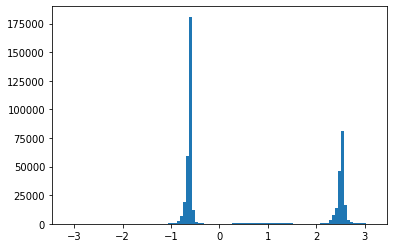

In [ ]:
plt.hist(phase_mat_ndim.ravel(), bins = 100)
plt.show()

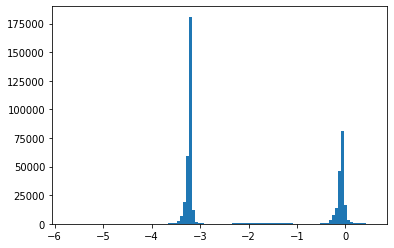

In [ ]:
phase_offset = 2.60

plt.hist(phase_mat_ndim.ravel() - phase_offset, bins = 100)
plt.show()

pr_mat_ndim = (amp_mat_ndim*np.cos(phase_mat_ndim+phase_offset))[:,:,:64]*1E5
pr_mat_ndim_lin = pr_mat_ndim.reshape((int(np.prod(pos_dim_sizes)),-1))

Plot averaged loop:

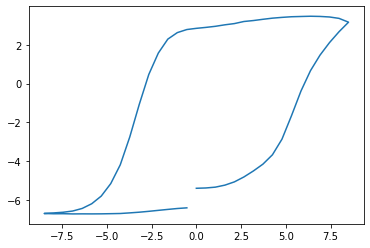

In [ ]:
plt.plot(spec_val[0,:64],pr_mat_ndim.mean(axis=(0,1)))
plt.show()

Plot spatial map at selected voltage:

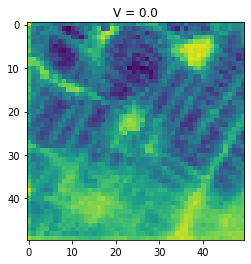

In [ ]:
voltage_step = 0

plt.imshow(pr_mat_ndim[:, :, voltage_step])
plt.title('V = {}'.format(spec_val[0, voltage_step]))
plt.show()

Gaussian process-based data cleaning (optional):

In [ ]:
do_gp = False # we may skip this part since the data is pretty clean

In [ ]:
if do_gp:

    import gpim
    X_full = gpim.utils.get_full_grid(pr_mat_ndim)
    R = pr_mat_ndim.copy()
    # Initiate and run GP reconstruction
    skreconstructor = gpim.skreconstructor(
        X_full, R, X_full, 
        kernel="RBF", lengthscale=None,
        sparse=True, grid_points_ratio=1., # Run GP with grid (structured) interpolation kernel
        learning_rate=0.1, iterations=150,
        use_gpu=True, precision='single',
        verbose=2
    )
    skreconstructor.train()
    gp_mean, gp_sd = skreconstructor.predict(num_batches=10)

In [ ]:
if do_gp:
    plt.imshow(gp_mean[..., 0])

In [ ]:
pr_mat_ndim = gp_mean.copy() if do_gp else pr_mat_ndim

Now let's do some basic decompositions to get a better understanding of the data:

In [ ]:
# Select number of components
nc = 16 

# Select decomposition type ('PCA' or 'NMF')
# Obviously, we have negative data here, so the non-negativity constraint is not needed
decomposition_type = 'PCA'

d1, d2, d3 = pr_mat_ndim.shape
X_vec = pr_mat_ndim.reshape(d1*d2, d3)

# Run decomposition
if decomposition_type == 'NMF':
    clf = decomposition.NMF(n_components=nc, random_state=42)
elif decomposition_type == 'PCA':
    clf = decomposition.PCA(n_components=nc, random_state=42)
else:
    raise NotImplementedError('Available methods: "PCA", "NMF"')

X_vec_t = clf.fit_transform(X_vec)
components = clf.components_
components = components.reshape(nc, d3)
print(components.shape, X_vec_t.shape)

(16, 64) (2500, 16)


Plot the decomposition results:

NUMBER OF COMPONENTS: 16
Components...


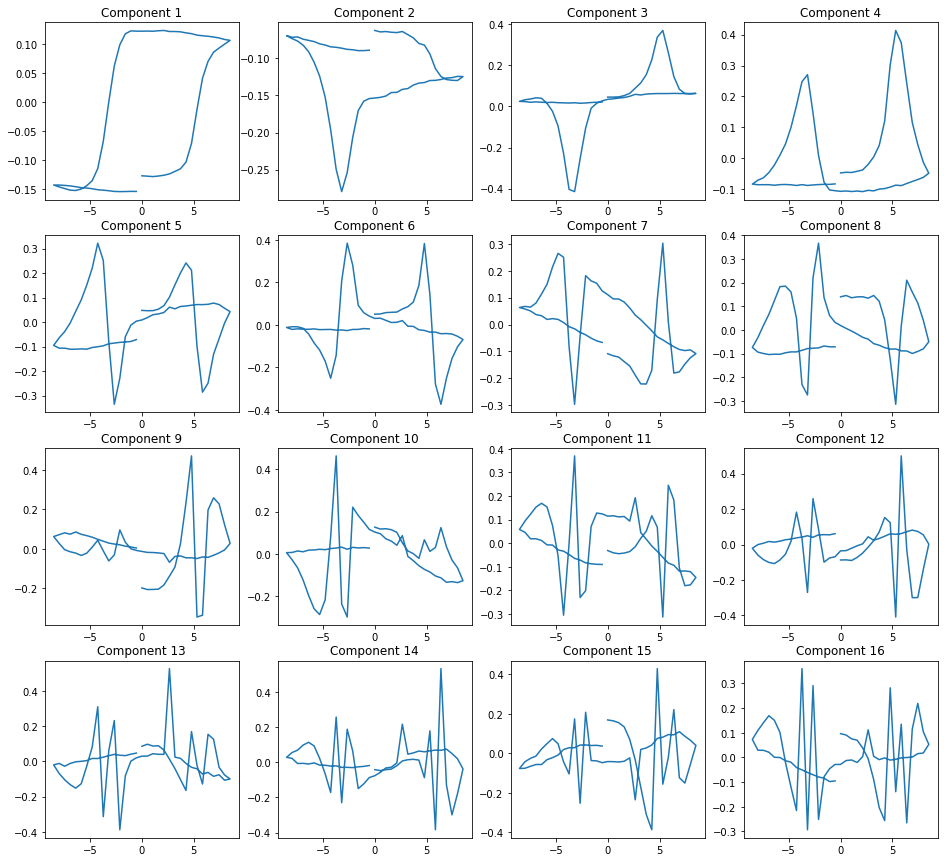

Abundance maps...


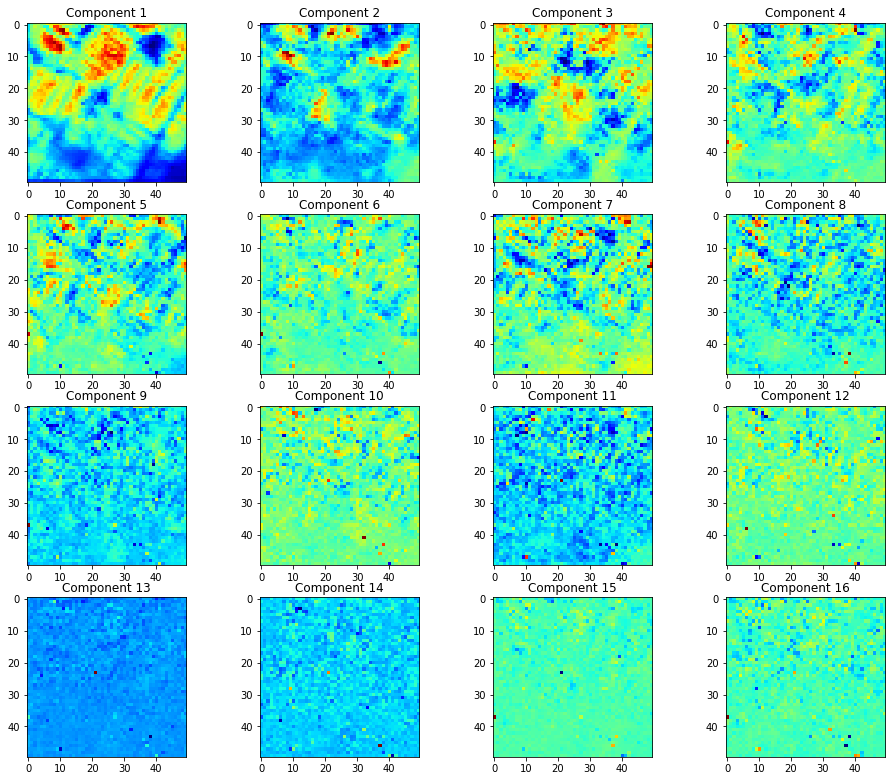

In [ ]:
rows = int(np.ceil(float(nc)/5))
cols = int(np.ceil(float(nc)/rows))

print('NUMBER OF COMPONENTS: ' + str(nc))
print('Components...')
gs1 = gridspec.GridSpec(rows, cols)
fig1 = plt.figure(figsize = (4*cols, 4.5*(1+rows)//1.5))   
for i in range(nc):
    ax1 = fig1.add_subplot(gs1[i])
    j = 0
    ax1.plot(spec_val[0,:64], components[i])
    ax1.set_title('Component ' + str(i + 1))
plt.show()

print('Abundance maps...')
gs2 = gridspec.GridSpec(rows, cols)
fig2 = plt.figure(figsize = (4*cols, 4.5*(1+rows//1.5)))   
for i in range(nc):
    ax2 = fig2.add_subplot(gs2[i])
    ax2.imshow(X_vec_t[:, i].reshape(d1, d2), cmap = 'jet')
    ax2.set_title('Component ' + str(i + 1))
plt.show()

# ML analysis

Here, we are going to:
- create a feature set formed by subsets of the image centered at specific location
- create a target set formed by the hysteresis loop at this location
- create *im2spec* encoder-decoder network that will transform the picture to spectra via latent bottleneck
- create *spec2im* network that will do the "inverse" transformation

## im2spec

Create a stack of subimages (features) and the associated loops (targets):

In [ ]:
def MakeWindow(imgsrc: np.ndarray, xpos: int, ypos: int) -> np.ndarray:
    """
    Returns the portion of the image within the window given the
    image (imgsrc), the x position and the y position
    """
    imgsrc = imgsrc[int(xpos-window_size/2):int(xpos+window_size/2), 
                    int(ypos-window_size/2):int(ypos+window_size/2)]
    return imgsrc

window_size = 16
voltage_step = 0

# Arrays to store images and loops
d1, d2, d3 = pr_mat_ndim.shape
feature_arr = np.zeros((window_size*window_size))
target_arr = np.zeros((d3))
info_arr= np.zeros((2))

s1, s2 = pr_mat_ndim[:,:,voltage_step].shape

for i in range(int(window_size/2), int(s1 - window_size/2)):
  for j in range(int(window_size/2), int(s2 - window_size/2)):
    arr_loc  = MakeWindow(pr_mat_ndim[:,:,voltage_step], i,j) 
    feature_arr = np.column_stack((feature_arr, arr_loc.reshape(window_size*window_size)))
    target_arr = np.column_stack((target_arr, pr_mat_ndim[i,j,:]))
    info_arr = np.column_stack((info_arr, (i,j)))

info_arr = info_arr[:, 1:].T
feature_arr = feature_arr[:, 1:].T.reshape(-1, window_size, window_size)
target_arr = target_arr[:, 1:].T

In [ ]:
print(feature_arr.shape)
print(target_arr.shape)
#plt.plot(spec_val[0,:64], target_arr[128,:])

(1156, 16, 16)
(1156, 64)


Create train/test sets:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    feature_arr[:, None, ...], target_arr[:, None, :],
    test_size=0.15, random_state=42, shuffle=True)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(982, 1, 16, 16) (982, 1, 64)
(174, 1, 16, 16) (174, 1, 64)


Define a helper function for reproducibility of model training in PyTorch:

In [ ]:
def rng_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available(): # for GPU
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

Define two main building blocks for our model:

In [ ]:
class dilated_block(nn.Module):
    """
    Creates a "pyramid" with dilated convolutional
    layers (aka atrous convolutions)
    """
    def __init__(self, ndim: int, input_channels: int, output_channels: int,
                 dilation_values: List, padding_values: List,
                 kernel_size: int = 3, stride: int = 1, lrelu_a: float = 0.01,
                 use_batchnorm: bool = False, dropout_: float = 0) -> None:
        """
        Initializes module parameters
        """
        super(dilated_block, self).__init__()
        conv_ = nn.Conv1d if ndim < 2 else nn.Conv2d 
        atrous_module = []
        for idx, (dil, pad) in enumerate(zip(dilation_values, padding_values)):
            input_channels = output_channels if idx > 0 else input_channels
            atrous_module.append(conv_(input_channels,
                                       output_channels,
                                       kernel_size=kernel_size,
                                       stride=stride,
                                       padding=pad,
                                       dilation=dil,
                                       bias=True))
            if dropout_ > 0:
                atrous_module.append(nn.Dropout(dropout_))
            atrous_module.append(nn.LeakyReLU(negative_slope=lrelu_a))
            if use_batchnorm:
                if ndim < 2:
                    atrous_module.append(nn.BatchNorm1d(output_channels))
                else:
                    atrous_module.append(nn.BatchNorm2d(output_channels))
        self.atrous_module = nn.Sequential(*atrous_module)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        """
        Forward path
        """
        atrous_layers = []
        for conv_layer in self.atrous_module:
            x = conv_layer(x)
            atrous_layers.append(x.unsqueeze(-1))
        return torch.sum(torch.cat(atrous_layers, dim=-1), dim=-1)


class conv_block(nn.Module):
    """
    Creates block of layers each consisting of convolution operation,
    leaky relu and (optionally) dropout and batch normalization
    """
    def __init__(self, ndim: int, nb_layers: int,
                 input_channels: int, output_channels: int,
                 kernel_size: int = 3, stride: int = 1, padding: int = 1,
                 use_batchnorm: bool = False, lrelu_a: float = 0.01,
                 dropout_: float = 0) -> None:
        """
        Initializes module parameters
        """
        super(conv_block, self).__init__()

        conv_ = nn.Conv1d if ndim < 2 else nn.Conv2d 
        block = []
        for idx in range(nb_layers):
            input_channels = output_channels if idx > 0 else input_channels
            block.append(conv_(input_channels,
                               output_channels,
                               kernel_size=kernel_size,
                               stride=stride,
                               padding=padding))
            if dropout_ > 0:
                block.append(nn.Dropout(dropout_))
            block.append(nn.LeakyReLU(negative_slope=lrelu_a))
            if use_batchnorm:
                if ndim < 2:
                    block.append(nn.BatchNorm1d(output_channels))
                else:
                    block.append(nn.BatchNorm2d(output_channels))
        self.block = nn.Sequential(*block)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward path
        """
        output = self.block(x)
        return output

Define *im2spec* model:

In [ ]:
class im2spec(nn.Module):
    """
    Encoder (2D) - decoder (1D) type model for generating spectra from image
    """
    def __init__(self,
                 feature_size: Tuple[int, int],
                 target_size: int,
                 latent_dim: int = 10,
                 nb_filters_enc: int = 64,
                 nb_filters_dec: int = 64) -> None:
        super(im2spec, self).__init__()
        self.n, self.m = feature_size
        self.ts = target_size
        self.e_filt = nb_filters_enc
        self.d_filt = nb_filters_dec
        # Encoder params
        self.enc_conv = conv_block(
            ndim=2, nb_layers=3,
            input_channels=1, output_channels=self.e_filt,
            lrelu_a=0.1, use_batchnorm=True)
        self.enc_fc = nn.Linear(self.e_filt * self.n * self.m, latent_dim)
        # Decoder params
        self.dec_fc = nn.Linear(latent_dim, self.d_filt*self.ts)
        self.dec_atrous = dilated_block(
            ndim=1, input_channels=self.d_filt, output_channels=self.d_filt,
            dilation_values=[1, 2, 3, 4], padding_values=[1, 2, 3, 4],
            lrelu_a=0.1, use_batchnorm=True)
        self.dec_conv = conv_block(
            ndim=1, nb_layers=1,
            input_channels=self.d_filt, output_channels=1,
            lrelu_a=0.1, use_batchnorm=True)
        self.dec_out = nn.Conv1d(1, 1, 1)
            
    def encoder(self, features: torch.Tensor) -> torch.Tensor:
        """
        The encoder embeddes the input image into a latent vector
        """
        x = self.enc_conv(features)
        x = x.reshape(-1, self.e_filt * self.m * self.n)
        return self.enc_fc(x)
    
    def decoder(self, encoded: torch.Tensor) -> torch.Tensor:
        """
        The decoder generates 1D signal from the embedded features
        """
        x = self.dec_fc(encoded)
        x = x.reshape(-1, self.d_filt, self.ts)
        x = self.dec_atrous(x)
        x = self.dec_conv(x)
        return self.dec_out(x)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward model"""
        encoded = self.encoder(x)
        return self.decoder(encoded)

Prepare data and initialize dataloaders:

In [ ]:
minibatch_size = 64
use_gpu = torch.cuda.is_available()

# Prepare data
if isinstance(X_train, np.ndarray):
    tor = lambda x: torch.from_numpy(x).float()
    X_train, X_test = tor(X_train), tor(X_test)
    y_train, y_test = tor(y_train), tor(y_test)

# Transfer to GPU device if available
if use_gpu:
    X_train = X_train.cuda()
    y_train = y_train.cuda()
    X_test = X_test.cuda()
    y_test = y_test.cuda()
    
# Initialize dataloader
data_train = torch.utils.data.TensorDataset(X_train, y_train)
data_test = torch.utils.data.TensorDataset(X_test, y_test)
train_iterator = torch.utils.data.DataLoader(
    data_train, batch_size=minibatch_size, shuffle=True)
test_iterator = torch.utils.data.DataLoader(data_test, batch_size=minibatch_size)

Train a model:

In [ ]:
num_epochs = 200 # number of training epochs
latent_dim = 10 # number of latent dimensions
feature_size = (16, 16)
target_size = 64
rng_seed(1) # for reproducibility

# Initialize model
ed = im2spec(feature_size, target_size, latent_dim)

if use_gpu:
    torch.cuda.empty_cache()
    ed.cuda()

# Specify optimizer and loss criterion
optimizer = torch.optim.Adam(ed.parameters(), lr=1e-3)
criterion = nn.MSELoss()
train_losses = []
test_losses = []

# Model training
for e in range(num_epochs):
    c, c_test = 0, 0
    losses, losses_test = 0, 0
    ed.train()
    for feature, target in train_iterator:
        b = feature.size(0)
        y_predicted = ed.forward(feature)
        loss = criterion(y_predicted, target)
        loss.backward()
        optimizer.step() 
        optimizer.zero_grad()
        losses += loss.item()
        c += b
    else:
        ed.eval()
        with torch.no_grad():
            for feature, target in test_iterator:
                b = feature.size(0)
                y_predicted = ed.forward(feature)
                loss = criterion(y_predicted, target)
                losses_test += loss.item()
                c_test += b
    train_losses.append(losses / c)
    test_losses.append(losses_test / c_test)
    print('Epoch: {}... Training loss: {}... Test loss: {}'.format(
        e, np.round(train_losses[-1], 5), np.round(test_losses[-1], 5)))

ed.cpu()
X_test, y_test = X_test.cpu(), y_test.cpu()
X_train, y_train = X_train.cpu(), y_train.cpu()

Epoch: 0... Training loss: 0.47727... Test loss: 0.50847
Epoch: 1... Training loss: 0.4746... Test loss: 0.49827
Epoch: 2... Training loss: 0.47138... Test loss: 0.49647
Epoch: 3... Training loss: 0.46277... Test loss: 0.49259
Epoch: 4... Training loss: 0.45958... Test loss: 0.48892
Epoch: 5... Training loss: 0.45113... Test loss: 0.48163
Epoch: 6... Training loss: 0.453... Test loss: 0.47387
Epoch: 7... Training loss: 0.44397... Test loss: 0.46805
Epoch: 8... Training loss: 0.44018... Test loss: 0.46226
Epoch: 9... Training loss: 0.42973... Test loss: 0.45786
Epoch: 10... Training loss: 0.42613... Test loss: 0.44938
Epoch: 11... Training loss: 0.4212... Test loss: 0.44762
Epoch: 12... Training loss: 0.41634... Test loss: 0.43205
Epoch: 13... Training loss: 0.40996... Test loss: 0.43241
Epoch: 14... Training loss: 0.40362... Test loss: 0.43045
Epoch: 15... Training loss: 0.39711... Test loss: 0.41732
Epoch: 16... Training loss: 0.38767... Test loss: 0.40964
Epoch: 17... Training loss: 

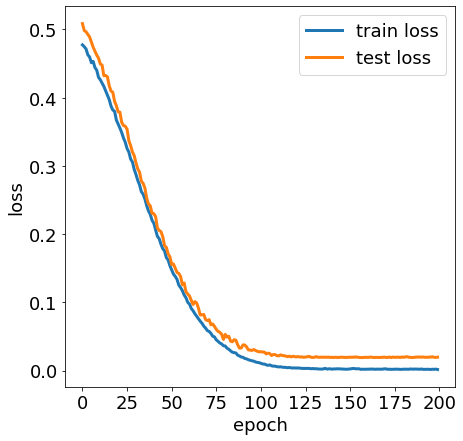

In [ ]:
plt.figure(figsize=(7,7))
plt.plot(train_losses, linewidth=3)
plt.plot(test_losses, linewidth=3)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('loss', fontsize=18)
plt.xlabel('epoch', fontsize=18)
plt.legend(['train loss', 'test loss'], loc='upper right', fontsize=18)
plt.show()

Predict on test data:

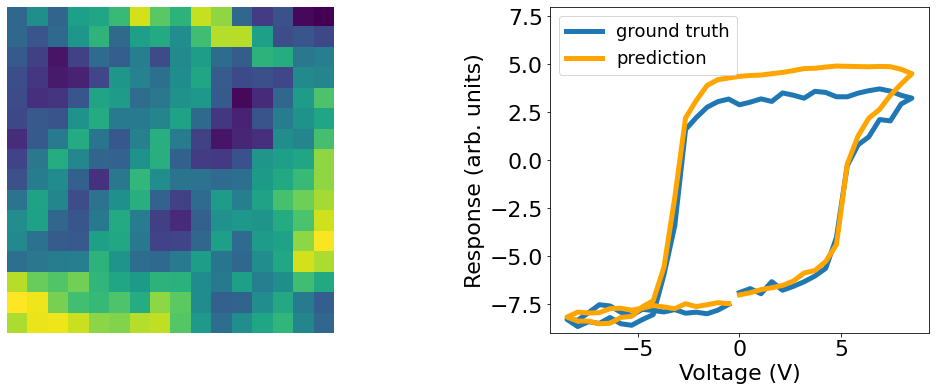

In [ ]:
k = 7 # number of image from validation set for testing

# Make prediction
with torch.no_grad():
    prediction = ed.forward(X_test[k:k+1])

# Plot results
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 6))
ax1.imshow(X_test[k, 0])
ax1.axis(False)
ax2.plot(spec_val[0,:64], y_test[k, 0], linewidth=5, label='ground truth')
ax2.plot(spec_val[0,:64], prediction[0, 0], linewidth=5, color='orange', label='prediction')
ax2.set_xlabel("Voltage (V)", fontsize=22)
ax2.set_ylabel("Response (arb. units)", fontsize=22)
ax2.tick_params(axis='both', which='major', labelsize=22)
ax2.set_ylim(-9, 8)
#plt.xticks(fontsize=24)
#plt.yticks(fontsize=24)
ax2.legend(fontsize=18, loc='upper left')
plt.subplots_adjust(wspace=0.5)

Visualize error for training data:

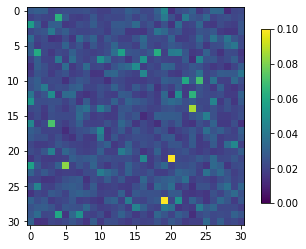

In [ ]:
with torch.no_grad():
    pred_loop = ed.forward(X_train[:-21]) # we cut off the last 21 inputs so that it can be reshaped into a square
pred_loop = pred_loop[:, 0, :]
error = (torch.mean((pred_loop-y_train[:-21, 0])**2, dim=1) /
         torch.mean((pred_loop+y_train[:-21, 0])**2, dim= 1))**(1/2)
plt.imshow(error.reshape(31, 31), vmin=0, vmax=0.1)
plt.colorbar(shrink = 0.8, format = '%.2f');

Now for test data:

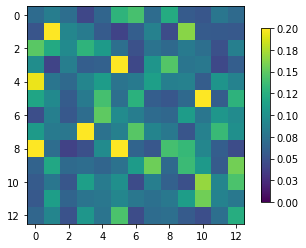

In [ ]:
with torch.no_grad():
    pred_loop = ed.forward(X_test[:-5]) # we cut off the last 5 inputs so that it can be reshaped into a square
pred_loop = pred_loop[:, 0, :]
error = (torch.mean((pred_loop-y_test[:-5, 0])**2, dim=1) / 
         torch.mean((pred_loop+y_test[:-5, 0])**2, dim= 1))**(1/2)
plt.imshow(error.reshape(13, 13), vmin=0, vmax=0.2)
plt.colorbar(shrink = 0.8, format = '%.2f');

... and for the entire dataset:

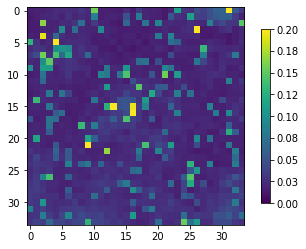

In [ ]:
with torch.no_grad():
    pred_loop = ed.forward(torch.from_numpy(feature_arr[:, None, ...]).float())
pred_loop = pred_loop[:, 0, :].numpy()
error = (np.mean((pred_loop-target_arr)**2,axis = 1) /
         np.mean((pred_loop+target_arr)**2,axis = 1))**(1/2)
plt.imshow(error.reshape(34,34), vmin = 0, vmax = 0.2)
plt.colorbar(shrink = 0.8, format = '%.2f');

Now let's get latent variables and analyze them:

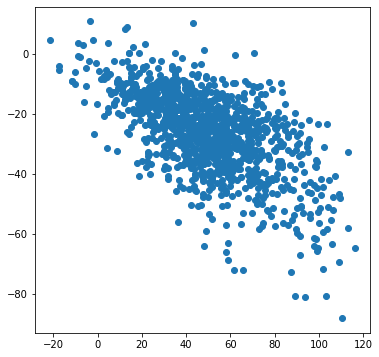

In [ ]:
with torch.no_grad():
    latent_features = ed.encoder(torch.from_numpy(feature_arr[:, None,...]).float())
plt.figure(figsize=(6, 6))
plt.scatter(latent_features[:,0], latent_features[:,1]);

Run Gaussian mixture model (GMM) decomposition on the latent variables:

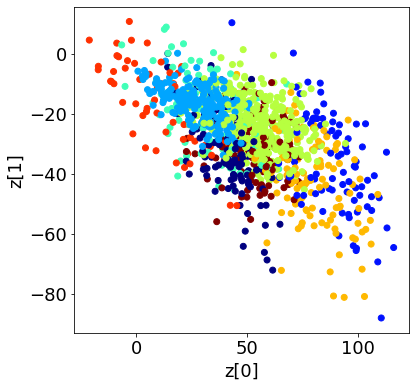

In [ ]:
nc = 8
gmmp = GaussianMixture(n_components=nc, random_state=42)
gmm_zp = gmmp.fit_predict(latent_features)

plt.figure(figsize=(6,6))
plt.scatter(latent_features[:, 0], latent_features[:,1], c=gmm_zp, cmap="jet")
plt.xlabel("z[0]", fontsize = 18)
plt.ylabel("z[1]", fontsize = 18)
plt.tick_params(labelsize = 18)

Get the loops associated with GMM components:

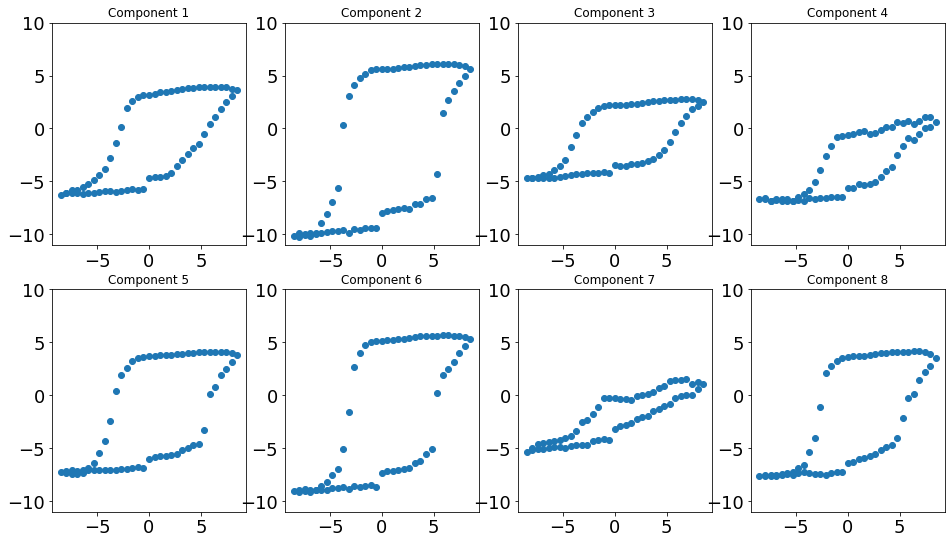

In [ ]:
nc = 8 # number of components
gmmp = GaussianMixture(n_components=nc, random_state=42) # add random state for reproducibility in the component ordering
centroids = gmmp.fit(latent_features).means_

rows = int(np.ceil(float(nc)/4))
cols = int(np.ceil(float(nc)/rows))

gs2 = gridspec.GridSpec(rows, cols)
fig2 = plt.figure(figsize = (4*cols, 4.5*(1+rows//1.5)))   
for i, centroid in enumerate(centroids):
    ax2 = fig2.add_subplot(gs2[i])
    ax2.scatter(spec_val[0,:64], torch.squeeze(ed.decoder(torch.from_numpy(centroid).float()).detach()))
    ax2.set_title('Component ' + str(i + 1))
    plt.tick_params(labelsize = 18)
    plt.ylim(-11, 10)
plt.show()

Find patches that give specific loops:

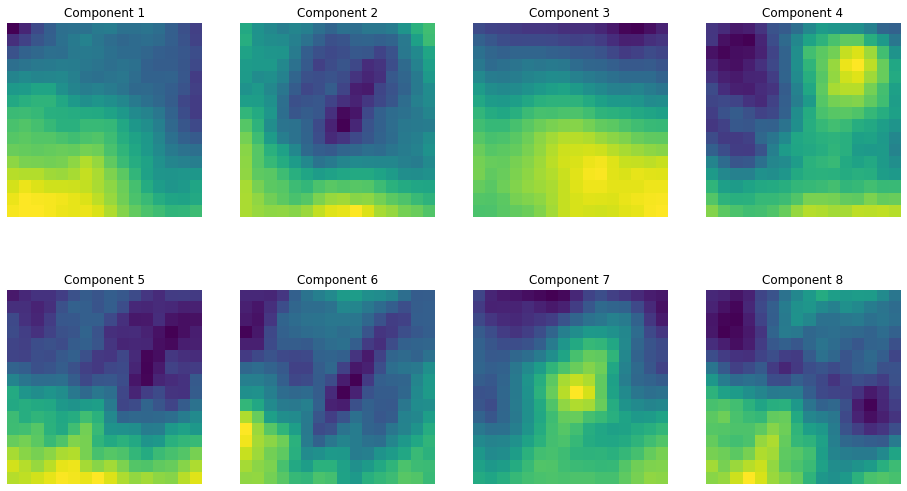

In [ ]:
rows = int(np.ceil(float(nc)/4))
cols = int(np.ceil(float(nc)/rows))

gs2 = gridspec.GridSpec(rows, cols)
fig2 = plt.figure(figsize = (4*cols, 4.5*(1+rows//1.5)))   
for i, centroid in enumerate(centroids):
    ax2 = fig2.add_subplot(gs2[i])

    comp_arr = []
    for n, feature in enumerate(latent_features.numpy()):
      comp = np.sum((feature[:]-np.squeeze(centroids[i]))**2)
      comp_arr = np.append(comp_arr, comp)
    loc_im = feature_arr[np.argsort(comp_arr)[:100],:, :].mean(axis = 0)
    ax2.imshow(loc_im)
    ax2.set_title('Component ' + str(i + 1))
    plt.tick_params(labelsize = 18)
    ax2.axis(False)
plt.show()

Do the "inverse" encoder trick to get continous representation for the features (works only for 2 latent dimensions):

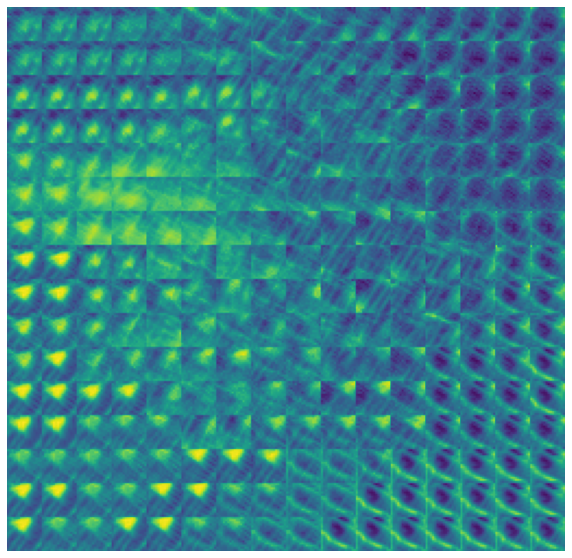

In [ ]:
if latent_features.shape[-1] != 2:
    raise ValueError("Your latent vector last dimension must be equal to 2")

xmin = latent_features[:, 0].min()
ymin = latent_features[:, 1].min()
xmax = latent_features[:, 0].max()
ymax = latent_features[:, 1].max()

n = 16
window_size1 = 16
window_size2 = 16
figure = np.zeros((window_size1 * n, window_size2 * n))

# linearly spaced coordinates corresponding to the 2D plot
# of spectrum classes in the latent space
grid_x = np.linspace(xmin, xmax, n)
grid_y = np.linspace(ymin, ymax, n)[::-1]
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z = np.array([[xi, yi]])

        comp_arr = []
        for n, feature in enumerate(latent_features):
          comp = torch.sum((feature[:]-np.squeeze(z))**2)
          comp_arr.append(comp)
        loc_im = feature_arr[torch.argsort(torch.Tensor(comp_arr))[:3],:, :].mean(axis = 0)

        figure[i * window_size1: (i + 1) * window_size1,
                j * window_size2: (j + 1) * window_size2] = loc_im

plt.figure(figsize=(10, 10))
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap='viridis', aspect = 'auto')
plt.axis(False)
plt.show()

## spec2im

Now we are going to interchange target and features and constuct *spec2im* network to predict 2D images from 1D loops.

Create *spec2im* model:

In [ ]:
class spec2im(nn.Module):
    """
    Encoder (2D) - decoder (1D) type model for generating spectra from image
    """
    def __init__(self,
                 feature_size: int,
                 target_size: Tuple[int, int],
                 latent_dim: int = 10,
                 nb_filters_enc: int = 64,
                 nb_filters_dec: int = 64) -> None:
        super(spec2im, self).__init__()
        self.n, self.m = target_size
        self.fs = feature_size
        self.e_filt = nb_filters_enc
        self.d_filt = nb_filters_dec
        # Encoder params
        self.enc_conv = conv_block(
            ndim=1, nb_layers=4,
            input_channels=1, output_channels=self.e_filt,
            lrelu_a=0.1, use_batchnorm=True)
        self.enc_fc = nn.Linear(self.e_filt * self.fs, latent_dim)
        # Decoder params
        self.dec_fc = nn.Linear(latent_dim, self.d_filt * (self.n // 4) * (self.m // 4))
        self.dec_conv_1 = conv_block(
            ndim=2, nb_layers=1,
            input_channels=self.d_filt, output_channels=self.d_filt,
            lrelu_a=0.1, use_batchnorm=True)
        self.dec_conv_2 = conv_block(
            ndim=2, nb_layers=1,
            input_channels=self.d_filt, output_channels=self.d_filt,
            lrelu_a=0.1, use_batchnorm=True)
        self.dec_atrous = dilated_block(
            ndim=2, input_channels=self.d_filt, output_channels=self.d_filt,
            dilation_values=[1, 2, 3, 4], padding_values=[1, 2, 3, 4],
            lrelu_a=0.1, use_batchnorm=True)
        self.dec_conv_3 = conv_block(
            ndim=2, nb_layers=1,
            input_channels=self.d_filt, output_channels=1,
            lrelu_a=0.1, use_batchnorm=True)
        self.dec_out = nn.Conv2d(1, 1, 1)
            
    def encoder(self, features: torch.Tensor) -> torch.Tensor:
        """
        The encoder embeddes the imput signal into a latent vector
        """
        x = self.enc_conv(features)
        x = x.reshape(-1, self.e_filt * self.fs)
        return self.enc_fc(x)
    
    def decoder(self, encoded: torch.Tensor) -> torch.Tensor:
        """
        The decoder generates 2D image from the embedded features
        """
        x = self.dec_fc(encoded)
        x = x.reshape(-1, self.d_filt, self.n//4, self.m//4)
        x = self.dec_conv_1(x)
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        x = self.dec_conv_2(x)
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        x = self.dec_atrous(x)
        x = self.dec_conv_3(x)
        return self.dec_out(x)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward model"""
        encoded = self.encoder(x)
        return self.decoder(encoded)

Create another training set, this time input is 1d signal and output is 2d image.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    target_arr[:, None, :], feature_arr[:, None, ...],
    test_size=0.15, random_state=42, shuffle=True)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(982, 1, 64) (982, 1, 16, 16)
(174, 1, 64) (174, 1, 16, 16)


Prepare data and initialize dataloaders:

In [ ]:
minibatch_size = 64
use_gpu = torch.cuda.is_available()


# Prepare data
if isinstance(X_train, np.ndarray):
    tor = lambda x: torch.from_numpy(x).float()
    X_train, X_test = tor(X_train), tor(X_test)
    y_train, y_test = tor(y_train), tor(y_test)

# Move to GPU if available
if use_gpu:
    X_train = X_train.cuda()
    y_train = y_train.cuda()
    X_test = X_test.cuda()
    y_test = y_test.cuda()
    
# Initialize dataloader
data_train = torch.utils.data.TensorDataset(X_train, y_train)
data_test = torch.utils.data.TensorDataset(X_test, y_test)
train_iterator = torch.utils.data.DataLoader(
    data_train, batch_size=minibatch_size, shuffle=True)
test_iterator = torch.utils.data.DataLoader(data_test, batch_size=minibatch_size)

Train *spec2im* model:

In [ ]:
num_epochs = 200 # number of training epochs
latent_dim = 10 # number of latent dimensions
feature_size = 64
target_size = (16, 16)
rng_seed(1) # for reproducibility

ed = spec2im(feature_size, target_size, latent_dim)
if use_gpu:
    torch.cuda.empty_cache()
    ed.cuda()
optimizer = torch.optim.Adam(ed.parameters(), lr=1e-3)
criterion = nn.MSELoss()
train_losses = []
test_losses = []
for e in range(num_epochs):
    c, c_test = 0, 0
    losses, losses_test = 0, 0
    ed.train()
    for feature, target in train_iterator:
        b = feature.size(0)
        y_predicted = ed.forward(feature)
        loss = criterion(y_predicted, target)
        loss.backward()
        optimizer.step() 
        optimizer.zero_grad()
        losses += loss.item()
        c += b
    else:
        ed.eval()
        with torch.no_grad():
            for feature, target in test_iterator:
                b = feature.size(0)
                y_predicted = ed.forward(feature)
                loss = criterion(y_predicted, target)
                losses_test += loss.item()
                c_test += b
    train_losses.append(losses / c)
    test_losses.append(losses_test / c_test)
    print('Epoch: {}... Training loss: {}... Test loss: {}'.format(
        e, np.round(train_losses[-1], 5), np.round(test_losses[-1], 5)))

ed.cpu()
X_test, y_test = X_test.cpu(), y_test.cpu()
X_train, y_train = X_train.cpu(), y_train.cpu()

Epoch: 0... Training loss: 0.71147... Test loss: 0.78324
Epoch: 1... Training loss: 0.70393... Test loss: 0.76083
Epoch: 2... Training loss: 0.69908... Test loss: 0.78681
Epoch: 3... Training loss: 0.69438... Test loss: 0.75277
Epoch: 4... Training loss: 0.68709... Test loss: 0.75702
Epoch: 5... Training loss: 0.6828... Test loss: 0.72947
Epoch: 6... Training loss: 0.6757... Test loss: 0.74321
Epoch: 7... Training loss: 0.6702... Test loss: 0.72098
Epoch: 8... Training loss: 0.66175... Test loss: 0.68871
Epoch: 9... Training loss: 0.65482... Test loss: 0.74239
Epoch: 10... Training loss: 0.64745... Test loss: 0.69277
Epoch: 11... Training loss: 0.64068... Test loss: 0.68317
Epoch: 12... Training loss: 0.6348... Test loss: 0.67708
Epoch: 13... Training loss: 0.62889... Test loss: 0.68705
Epoch: 14... Training loss: 0.62131... Test loss: 0.64818
Epoch: 15... Training loss: 0.61357... Test loss: 0.67952
Epoch: 16... Training loss: 0.60427... Test loss: 0.63278
Epoch: 17... Training loss: 

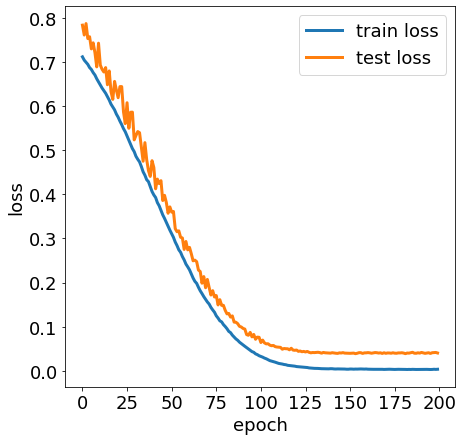

In [ ]:
plt.figure(figsize=(7,7))
plt.plot(train_losses, linewidth=3)
plt.plot(test_losses, linewidth=3)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('loss', fontsize=18)
plt.xlabel('epoch', fontsize=18)
plt.legend(['train loss', 'test loss'], loc='upper right', fontsize=18)
plt.show()

Make a prediction on test data:

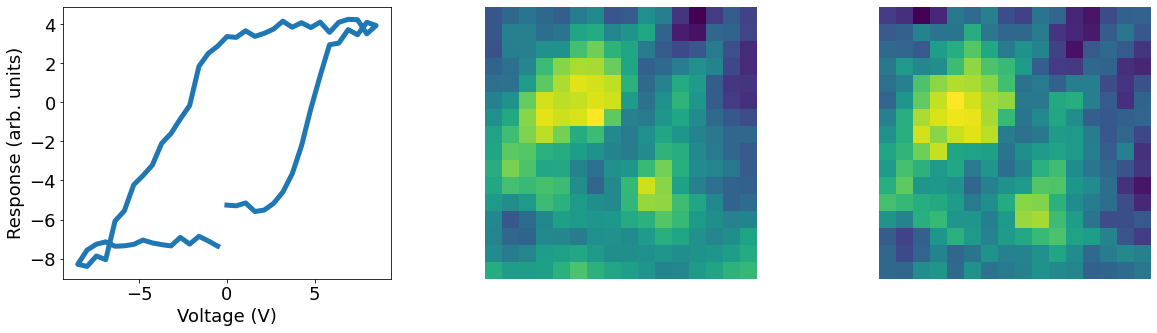

In [ ]:
k = 9 # spectrum number

# prediction with a trained model
with torch.no_grad():
    prediction = ed.forward(X_test[k:k+1])
# plot results
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
ax1.plot(spec_val[0,:64], X_test[k, 0, :], linewidth=5)
ax1.set_xlabel("Voltage (V)", fontsize=18)
ax1.set_ylabel("Response (arb. units)", fontsize=18)
ax1.tick_params(axis='both', which='major', labelsize=18)
ax2.imshow(prediction[0,0])
ax2.axis(False)
ax3.imshow(y_test[k, 0])
ax3.axis(False)
plt.show()

Error on training set:

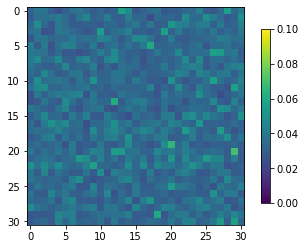

In [ ]:
with torch.no_grad():
    pred_im = ed.forward(X_train[:-21])
pred_im = pred_im[:, 0, ...]
error = (torch.mean((pred_im-y_train[:-21,0])**2, dim=(1,2)) /
         (torch.mean((pred_im+y_train[:-21,0])**2, dim=(1,2))))**(1/2)
plt.imshow(error.reshape(31,31), vmin = 0, vmax = 0.1)
plt.colorbar(shrink = 0.8, format = '%.2f')

Error on test set:

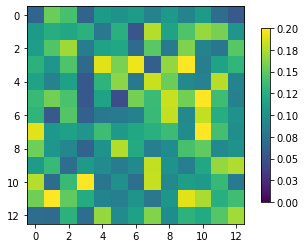

In [ ]:
with torch.no_grad():
    pred_im = ed.forward(X_test[:-5])
pred_im = pred_im[:, 0, ...]
error = (torch.mean((pred_im-y_test[:-5,0])**2, dim=(1,2)) /
         (torch.mean((pred_im+y_test[:-5,0])**2, dim=(1,2))))**(1/2)
plt.imshow(error.reshape(13,13), vmin=0, vmax=0.2)
plt.colorbar(shrink=0.8, format = '%.2f')

Error on the entire dataset:

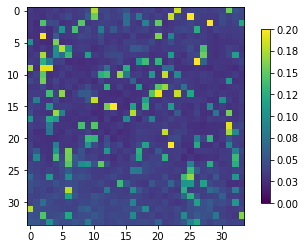

In [ ]:
with torch.no_grad():
    pred_im = ed.forward(torch.from_numpy(target_arr[:, None, :]).float())
pred_im = pred_im[:, 0, ...].numpy()
error = (np.mean((pred_im-feature_arr)**2,axis = (1,2)) /
         (np.mean((pred_im+feature_arr)**2,axis = (1,2))))**(1/2)
plt.imshow(error.reshape(34,34), vmin = 0, vmax = 0.2)
plt.colorbar(shrink = 0.8, format = '%.2f')

Just as in the case of *im2spec*, let's study latent variables:

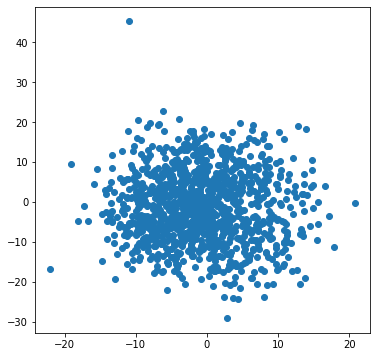

In [ ]:
with torch.no_grad():
    latent_features = ed.encoder(torch.from_numpy(target_arr[:, None, :]).float())
plt.figure(figsize=(6, 6))
plt.scatter(latent_features[:,0], latent_features[:,1]);

Perform GMM on the encoded (latent) features:

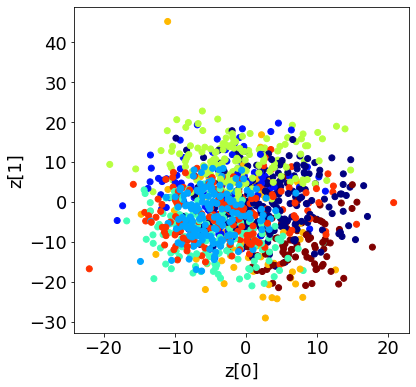

In [ ]:
gmmp = GaussianMixture(n_components=8, random_state=42)
gmm_zp = gmmp.fit_predict(latent_features)

plt.figure(figsize=(6,6))
plt.scatter(latent_features[:, 0], latent_features[:,1], c=gmm_zp, cmap="jet")
plt.xlabel("z[0]", fontsize = 18)
plt.ylabel("z[1]", fontsize = 18)
plt.tick_params(labelsize = 18)

Compute GMM centroids and apply the trained decoder to each of them:

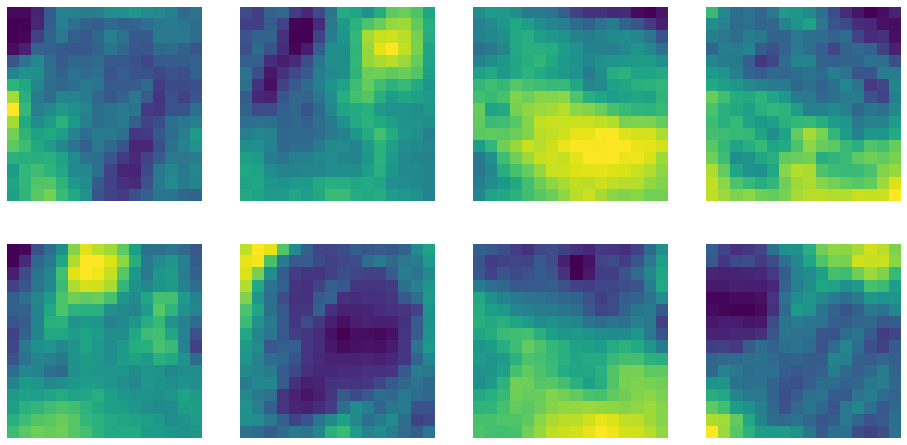

In [ ]:
nc = 8
gmmp = GaussianMixture(n_components=nc, random_state=42)
centroids = gmmp.fit(latent_features).means_

rows = int(np.ceil(float(nc)/4))
cols = int(np.ceil(float(nc)/rows))

gs2 = gridspec.GridSpec(rows, cols)
fig2 = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))   
for i, centroid in enumerate(centroids):
    ax2 = fig2.add_subplot(gs2[i])
    ax2.imshow(torch.squeeze(
        ed.decoder(torch.from_numpy(centroid).float())).reshape(window_size, window_size).detach())
    #ax2.set_title('Component ' + str(i + 1))
    plt.tick_params(labelsize = 0)
    ax2.axis(False)
plt.show()

Can we find loops that give outputs closest to centroids? Using the fact that they are enumerated, we are going to find i, j indices closest to centroids and then average.

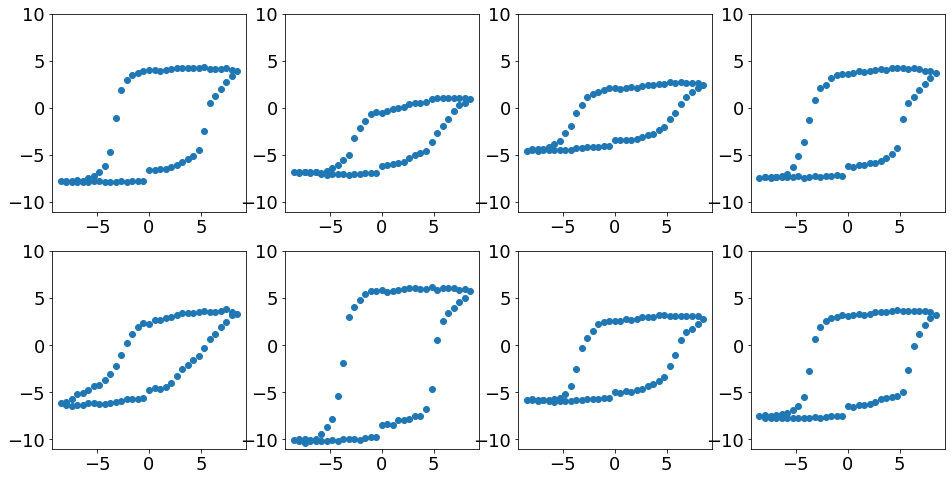

In [ ]:
rows = int(np.ceil(float(nc)/4))
cols = int(np.ceil(float(nc)/rows))

gs2 = gridspec.GridSpec(rows, cols)
fig2 = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))   
for i, centroid in enumerate(centroids):
    ax2 = fig2.add_subplot(gs2[i])

    comp_arr = []
    for n, feature in enumerate(latent_features.numpy()):
      comp = np.sum((feature[:]-np.squeeze(centroids[i]))**2)
      comp_arr = np.append(comp_arr, comp)

    loc_loop = target_arr[np.argsort(comp_arr)[:10],:].mean(axis = 0)
    ax2.scatter(spec_val[0,:64], loc_loop)
    #ax2.set_title('Component ' + str(i + 1))
    plt.ylim((-11,10))
    plt.tick_params(labelsize = 18)
plt.show()

Finally, we reconstruct a 2D manifold with different domain structures from the latent variables:

(works only for 2 latent dimensions)

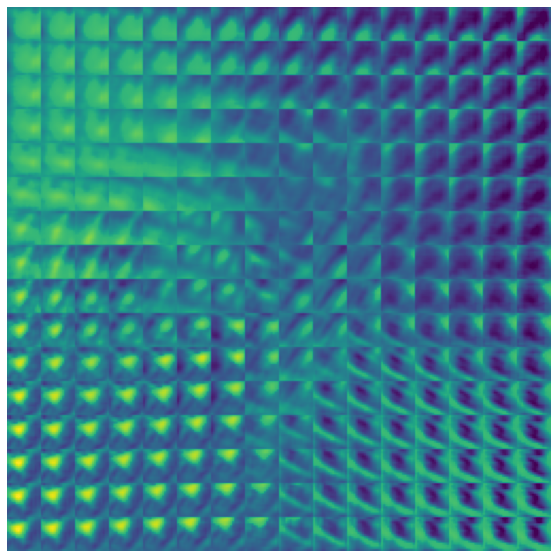

In [ ]:
if latent_features.shape[-1] != 2:
    raise ValueError("Your latent vector last dimension must be equal to 2")

xmin = latent_features[:, 0].min()
ymin = latent_features[:, 1].min()
xmax = latent_features[:, 0].max()
ymax = latent_features[:, 1].max()

n = 16
window_size1 = 16
window_size2 = 16
figure = np.zeros((window_size1 * n, window_size2 * n))

# linearly spaced coordinates corresponding to the 2D plot
# of spectrum classes in the latent space
grid_x = np.linspace(xmin, xmax, n)
grid_y = np.linspace(ymin, ymax, n)[::-1]
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z = torch.Tensor([[xi, yi]])
        with torch.no_grad():
            x_decoded = ed.decoder(z)
        local_im = x_decoded[0].reshape(window_size, window_size)
        figure[i * window_size: (i + 1) * window_size,
                j * window_size: (j + 1) * window_size] = local_im

plt.figure(figsize=(10, 10))
start_range = window_size // 2
end_range = n * window_size + start_range + 1
pixel_range = np.arange(start_range, end_range, window_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
#plt.xticks(pixel_range, sample_range_x)
#plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap='viridis', vmin=-10, vmax=0)
#plt.imshow(figure, cmap='viridis')
plt.axis("off")
plt.show()
